In [1]:
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload 2

# Evaluation

이번 프로젝트의 워크플로우는 크게 2 종류로 구성되어 있습니다. 

평가를 그에 따라 아래와 같이 진행할 것입니다. 

1. lite 워크플로우 평가
2. router 노드 평가
3. deep 워크플로우 평가 


### Lite 워크플로우 평가
Lite 워크플로우는 최신성을 중점으로 평가하였습니다. 
Ko-freshqa 데이터 셋을 사용해 평가하였으며, 아래 주소에서 확인할 수 있습니다. 

### router 노드 평가

워크플로우가 질문에 따라 질문의 depth를 미리 파악하고, 질의가 단순하고 단일 검색으로 끝날 만한 것이라면,    
router 노드가 lite 워크플로우로 분기합니다. 그에 따라 문제를 정확히 이해하고 어느 정도의 추론이 필요한지 미리 파악하는 것이 중요합니다. 

ko-freshqa 데이터 셋과 deep 노드에서 사용할 만한 쿼리로 데이터 셋을 구성하고, 정확도를 측정하였습니다.    
또한 추론 이유도 함께 뽑아내어 왜 router가 그 노드로 분기시겼는지 확인하였습니다. 

### Deep 워크플로우 평가

딥리서치 워크플로우는 제작된 gold 쿼리 데이터 셋을 사용해 평가하였습니다.   
각 샘플은 **사용자 질문**과 이에 대응하는 **정답 InfluenceReport(JSON)** 으로 구성되어 있으며,   
시스템이 생성한 리포트와 gold 리포트를 비교하는 방식으로 성능을 측정했습니다. 

평가는 다음 두 가지 관점에서 수행했습니다.

* 🟢 **Relaxed Evaluation (완화 평가)**

  * **사실이고, 의미적으로 타당한 대안 답변**까지 인정하는 평가 방식입니다.
  * 시스템 출력이 gold와 정확히 일치하지 않더라도,

    * 동일한 정치인에 대해,
    * 현실에서 실제로 존재하는 정책·사건·기업 관계를 근거 기반으로 설명하고,
    * 질문의 의도(예: “이재명의 정치–경제 영향력 네트워크를 설명하라”)에 **충분히 부합**하는 경우
      **부분 정답 또는 대안 정답**으로 간주합니다.
  * 이때는 LLM-as-Judge 또는 휴먼 리뷰를 활용하여
    0~1 또는 0~5 점수처럼 **연속적인 점수**를 부여하고,
    샘플별 점수를 평균 내어 Relaxed 스코어를 계산합니다.
  * 즉, **“골드와 다르지만 합리적인 다른 해석”**도 성능으로 인정하는 방향의 평가입니다.

* 🔴 **Strict Evaluation (엄격 평가)**

  * gold 리포트에 정의된 **핵심 체인**을 기준으로,

    * 정책/이슈 영역,
    * 산업/섹터,
    * 주요 기업(또는 must_cover 엔티티)가 **충분히 겹치지 않으면 오답**으로 처리하는 방식입니다.   
    
  * 예를 들어, gold가   
    `이재명 → 성남 FC 후원금 → 두산건설·네이버`   
    를 핵심 체인으로 정의했을 때, 시스템이   
    `이재명 → 대북송금 의혹(쌍방울) → 쌍방울그룹·나노스`   
    만을 제시하면, 실제로 존재하는 사건이라 하더라도   
    **gold가 강조한 테마를 포착하지 못한 것**으로 보고 낮은 점수를 부여합니다.   
  * Strict Evaluation에서는 must_cover로 지정한 정책·산업·기업의 **포함 여부**를 중심으로   
    정확도(accuracy) 또는 엔티티 단위 Precision/Recall 등을 집계하여 점수를 산출합니다.   
  * 즉, **“내가 정의한 테마를 얼마나 정확히 따라왔는가”** 를 보는 보수적인 평가입니다.


## Evaluation Agent

### Citation_faithfulness workflow
Hallucination, 실제 기사인지, 추론한 내용이 있는지 평가하는 워크플로우입니다. 

In [2]:
%pwd

'/Users/seyeong/workspace/Upstage_team3/deep_research/evaluation'

In [3]:
import os
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
from eval_graph import CombinedEvalState, combined_eval_app
from typing import Dict, Any, List, Optional


load_dotenv()


async def evaluate_report_evidence(
    model_report: Dict[str, Any],
    gold_report: Optional[Dict[str, Any]] = None,
    question: Optional[str] = None,
) -> Dict[str, Any]:
    """
    Run:
    - Impact Evidence Faithfulness (per-chain, multi-source)
    - Policy Attribution Consistency (per-chain, multi-source)
    - (optionally) Gold vs Model report comparison
    """
    question_for_gold = question or model_report.get("question_answer", "") or ""
    chains = model_report.get("influence_chains", [])

    all_chain_results: List[Dict[str, Any]] = []
    gold_eval: Optional[Dict[str, Any]] = None

    for idx, chain in enumerate(chains):
        # 1) 체인별 state 구성
        chain_state: CombinedEvalState = {
            "politician": chain.get("politician"),
            "policy": chain.get("policy"),
            "industry_or_sector": chain["industry_or_sector"],
            "companies": chain["companies"],
            "impact_description": chain["impact_description"],
            "question": question_for_gold,
            "evidence": chain.get("evidence", []),
        }

        # 2) gold vs model 비교는 질문/리포트 전체 기준이므로
        if gold_report is not None:
            chain_state["gold_report"] = gold_report
            chain_state["model_report"] = model_report

        # 3) 그래프 실행
        result_state = await combined_eval_app.ainvoke(chain_state)

        # 4) 체인별 결과 수집 (per-chain 단일 결과를 기대)
        impact_result = result_state.get("impact_result")
        attribution_result = result_state.get("attribution_result")

        # BaseModel이면 dict로 변환
        if hasattr(impact_result, "model_dump"):
            impact_result = impact_result.model_dump()
        if hasattr(attribution_result, "model_dump"):
            attribution_result = attribution_result.model_dump()

        all_chain_results.append(
            {
                "chain_index": idx,
                "politician": chain.get("politician"),
                "policy": chain.get("policy"),
                "industry_or_sector": chain["industry_or_sector"],
                "companies": chain["companies"],
                "impact_description": chain["impact_description"],
                "impact_result": impact_result,
                "attribution_result": attribution_result,
            }
        )

        # gold_eval 은 리포트 전체 기준이므로 한 번만 담기
        if gold_report is not None and gold_eval is None:
            gold_eval = result_state.get("gold_eval")
            if hasattr(gold_eval, "model_dump"):
                gold_eval = gold_eval.model_dump()
        
    print("gold_eval : : :", gold_eval)

    return {
        "chain_results": all_chain_results,
        "gold_eval": gold_eval,
    }




모델의 예시 출력

In [10]:
state = {'report_title': '이재명 정책-산업-기업 연결 분석 (증거 기반)',
 'time_range': '2025년 6월 기준',
 'question_answer': '이재명은 과거 근무 이력과 정책 수혜를 통해 여러 기업 및 산업과 연결되어 있으나, 재정적·자문적 관계는 확인되지 않음',
 'influence_chains': [{'politician': '이재명',
   'policy': '과거 근무 이력',
   'industry_or_sector': '제조업',
   'companies': ['오리엔트정공', '오리엔트바이오'],
   'impact_description': '이재명 후보의 과거 근무 이력으로 인해 관련주가 급등했으나, 기업은 직접적 관계 없음을 공식 부인함',
   'evidence': [{'source_title': '오리엔트시계공장 근무 이력 관련 기사',
     'url': 'https://weekly.donga.com/economy/article/all/11/5359813/1'}]},
  {'politician': '이재명',
   'policy': '신재생에너지 및 기후에너지 정책',
   'industry_or_sector': '재생에너지',
   'companies': ['HD Hyundai Energy Solutions', 'Hanwha Solutions'],
   'impact_description': '신재생에너지 정책 수혜 기업으로 명시됨',
   'evidence': [{'source_title': '재생에너지 정책 수혜 기업 기사',
     'url': 'https://www.yna.co.kr/view/AKR20250602117900008'}]},
  {'politician': '이재명',
   'policy': 'AI 산업 지원',
   'industry_or_sector': '반도체',
   'companies': ['삼성전자', 'SK하이닉스'],
   'impact_description': 'AI 산업 지원 정책의 수혜 기업으로 언급됨',
   'evidence': [{'source_title': 'AI 반도체 수혜 기업 기사',
     'url': 'https://biz.chosun.com/stock/stock_general/2025/06/04/46YIQPA6EZG3RPIOL742EPRGX4/'}]},
  {'politician': '이재명',
   'policy': '지역화폐 확대',
   'industry_or_sector': '핀테크',
   'companies': ['Kona I', 'Webcash'],
   'impact_description': '지역화폐 확대 정책의 수혜 기업으로 언급됨',
   'evidence': [{'source_title': '지역화폐 수혜 기업 기사',
     'url': 'https://www.g-enews.com/article/Securities/2025/06/202506041519069460288320b10e_1'}]}],
 'notes': ''}

In [4]:
state = {'report_title': '윤석열 대통령의 정책 및 산업별 영향력 분석',
 'time_range': '2025-12-03 기준',
 'question_answer': '윤석열 대통령은 에너지 정책 및 원전 확대, 반도체 산업 전략 등을 통해 에너지/원전 산업 및 반도체 산업의 주요 기업들과 연결되어 있습니다. 원전 관련 기업으로는 한국수력원자력, 두산에너빌리티, 삼성물산, 현대엔지니어링, SK그룹이 있으며, 반도체 관련 기업으로는 삼성전자, SK하이닉스, 네이버, 사피온코리아가 있습니다. 다만, 직접적인 로비 또는 금융적 유대에 대한 명확한 증거는 없습니다.',
 'influence_chains': [{'politician': '윤석열',
   'policy': '에너지 정책 및 원전 확대',
   'industry_or_sector': '에너지/원전 산업',
   'companies': ['한국수력원자력', '두산에너빌리티', '삼성물산', '현대엔지니어링', 'SK그룹'],
   'impact_description': '윤석열 정부는 원전 비중 확대 및 에너지 수요효율화 정책을 추진하며 한국수력원자력, 두산에너빌리티, 삼성물산, 현대엔지니어링, SK그룹 등 원전 및 에너지 관련 기업에 직접적인 영향을 미치고 있습니다. 원전 협력업체에 대한 투자 계획도 포함되어 있습니다.',
   'evidence': [{'source_title': '산업뉴스',
     'url': 'https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQH73D821mhgtVYnQQ5UmL2pBq-b7H3VGs3xZzXoiMhpW_mgiHbNgpgmqTjwNKL2nl6zYnImxTFqIPvE1h_nMN-WfP35awVL3ofdBH-m0PQPNnFoIbmDnYydi2HxWyMJpWu6eAgF4qpgqtmxh6X8MZBAzByeqRQprqJe8AY='},
    {'source_title': '한국에너지법학회',
     'url': 'https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHuJWtPw-qiTGFMBrmfNdkbCamrGKJ9oDQihy4-WOMLteLAlfcqOkgeQy7V8eqqh2zxDEFbo-bXpaOXXEE9L8kKiNWZKRD9lpf_hVaFjX97qHgi54nkyvnv6rdd04-fJPROLAqIHdu_TSH3bhWxjg=='},
    {'source_title': '산경신문',
     'url': 'https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHDbvouZl4k5XkdwjYDTMVxzMwQfXwCPA982YqfpE1CF4ca0OP54XTOpOm-YPO4f3PacBfFZmAQDU-nwybI54744lUk3CZl3bZrMM8aeNozrWRKzKb9Cyrjo-yvvBkf0LR0LcthEzSl4k1SBtEUoFgAdrnk2_61ycVxzyxIhv5K8OMgABvTzOIrxWDMvH5jz_IlKKJSI8nXP2-8xm5J4o8fRsmmNDGihnL4r56PuV1KCv5sD7NKLoc_Pc4ctQXn2PITODUDzRZCUtvNrp1Iku9IxIVNyVvT-gT2RB1Y6Fp2sRz-iQ2cQCZXvEhQeP5paU7hLRea9baC8bvwIAzJFHSL-8E='}]},
  {'politician': '윤석열',
   'policy': '반도체 산업 전략',
   'industry_or_sector': '반도체 산업',
   'companies': ['삼성전자', 'SK하이닉스', '네이버', '사피온코리아'],
   'impact_description': '윤석열 정부는 반도체 산업을 국가첨단전략산업으로 지정하고 규제 완화 및 세제 혜택을 확대하며 삼성전자, SK하이닉스, 네이버, 사피온코리아 등 반도체 관련 기업에 영향을 미치고 있습니다. K-반도체 벨트 이니셔티브도 추진 중입니다.',
   'evidence': [{'source_title': '김·장 법률사무소',
     'url': 'https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFCV-zytmHpCk0kpz3PXSVk6lJi30tv-MMABBEtoR6a0MkJglTmx7CFgj_4tYH70KeD_xWiB558t0YN-wQt_TLJZFlegmL6DX9CaBGW5oBf9-T0sjTfMg_1mS9ZbVs0UuUbKJ2sVpLAUUv8cKIEh-1ItOEdROhbSpufz_4jPVm1mAs='},
    {'source_title': '조선일보',
     'url': 'https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHiOEvSqYvsQmCKD475NduEfynC1XnAWBX9898G7ho3BQIC3FRkpq8nuAV7QRYyYYnJHDQxVGOsslPX52YZU8JofxP8X-xcafX_zQ8YLSo9kJGlsH08xusafxPREnmQThqp6xIBPYSiX8YYMLgHUf835DmSvPy6Tgx2sy2wZHZ3NKed3NzXVNvM7w6WOXrcBPfUhw=='}]}],
 'notes': ''}

### 단일 결과에 대한 평가

평가는 `evaluate_report_evidence`에 의해 이루어집니다.
모델은 3개의 하위 워크플로우에서 평가합니다.

우선, ChatGPT의 딥리서치 결과인 `gold_report`와 Deep Research 워크플로우가 생성한 결과를 비교합니다.

---

#### 1. Gold Report Alignment (골드 리포트 정합성 평가)

**무엇을 평가하는가?**

* 같은 정치인에 대해:

  * ChatGPT Deep Research가 생성한 `gold_report`
  * 우리 Deep Research 워크플로우가 생성한 `model_report`
    이 두 리포트가 **정책·산업·기업·영향관계 측면에서 얼마나 비슷한 구조와 내용을 가지는지**를 평가합니다.

**어떻게 평가하는가?**

* 하나의 노드에서 다음을 비교하도록 LLM을 호출합니다.

  * 두 리포트의 `question_answer`가 같은 정치인의 **핵심 정책 방향과 산업/기업 영향**을 비슷하게 설명하고 있는지
  * `influence_chains` 수준에서

    * 어떤 정책이 등장하는지
    * 어떤 산업/섹터를 다루는지
    * 어떤 기업들이 언급되는지
    * 각 기업/섹터가 **어떤 방향의 영향(수혜/피해, 성장/위축 등)**을 받는 것으로 설명되는지
* 이때 Gold는 “정답 레이블”이라기보다는,

  > *“딥리서치 시스템이 이상적으로 추구하는 레퍼런스 분석”*
  > 으로 취급되며,

  * 모델 리포트가 Gold와 얼마나 구조적으로/내용적으로 가까운지
  * 혹은 Gold에는 없지만 **더 설득력 있거나 추가적인 근거를 가진 설명**을 제시하는지까지 함께 판단하도록 설계할 수 있습니다.

즉, 이 단계는 “모델 전체 리포트가 우리가 원하는 타입의 분석으로 나왔는지”를 글로벌하게 비교·평가하는 역할을 합니다.

---

#### 2. Impact Evidence Faithfulness

*(기사 내용 vs 영향 설명 / 할루시네이션 검증)*

**무엇을 평가하는가?**

* 각 `influence_chain` 단위로,

  * `impact_description` (정책이 특정 산업/기업에 어떤 경제적 영향을 줬다고 모델이 주장하는 문장)
  * 해당 체인에 연결된 `evidence` URL들에서 스크래핑한 기사 본문 (`source_text`)
    를 비교해서,

> **“이 영향 설명이 실제 기사 내용에 의해 지지되는지 / 아니면 할루시네이션인지”**

를 평가합니다.

**어떻게 평가하는가?**

* `impact_evidence_faithfulness` 워크플로우는 다음 순서로 동작합니다.

  1. `scrape_urls_node`

     * 각 evidence URL을 열어 텍스트를 가져옵니다.
  2. `evaluate_impact_node`

     * 각 URL별로 LLM에게 다음 정보를 넘겨줍니다.

       * `industry_or_sector`
       * `companies`
       * `impact_description`
       * `source_title`, `url`, `source_text`
       * (옵션) `question` 컨텍스트
     * LLM은 **기사 내용 vs 영향 설명**을 비교해 다음 라벨 중 하나를 반환합니다.

       * `SUPPORTED`
       * `PARTIALLY_SUPPORTED`
       * `UNSUPPORTED`
       * `CONTRADICTED`
       * `NOT_ENOUGH_INFO`
     * 함께 `score`(0.0–1.0), `reasoning`(한국어 설명),
       그리고 기사 본문에서 뽑은 `evidence_spans`(관련 문장들)를 제공합니다.

**이 단계가 측정하는 것**

* 할루시네이션 여부:

  * `SUPPORTED / PARTIALLY_SUPPORTED` 비율이 높으면,
    → 모델이 기사의 근거 범위 내에서 합리적인 영향 설명을 생성하고 있다는 뜻
  * `UNSUPPORTED / CONTRADICTED`가 많으면,
    → 모델이 기사에 없는 내용 또는 반대 내용을 만들어내고 있다는 신호
* 또한, **영향 설명의 디테일(수치, 방향성, 수혜/피해 여부 등)이 기사와 얼마나 일치하는지**를 직접적으로 측정합니다.

---

#### 3. Policy Attribution Consistency

*(정치인·정책과 기사/URL의 관련성 평가)*

**무엇을 평가하는가?**

* 각 `influence_chain` 단위로,

  * 지정된 `politician` + `policy`
  * 해당 체인의 evidence URL로부터 가져온 기사
    사이의 **연관성**을 측정합니다.

> “이 URL은 정말로
> 이 정치인/정책과 관련된 기사인가?”
> “아니면 단지 산업/기업 이름만 같을 뿐, 정책·정치 맥락은 거의 없는 기사인가?”

**어떻게 평가하는가?**

* `policy_attribution_consistency` 워크플로우는 다음을 수행합니다.

  1. URL 스크래핑은 Impact와 동일하게 `scrape_urls_node`에서 처리 (공유)
  2. `evaluate_policy_attribution_node`에서 각 URL별로 LLM을 호출해 다음을 전달:

     * `politician`, `policy`
     * `industry_or_sector`, `companies`
     * `source_title`, `url`, `source_text`
     * (옵션) 질문 컨텍스트
  3. LLM은 기사와 (politician, policy) 관계를 평가해서:

     * `label`:

       * `HIGHLY_RELATED`
       * `WEAKLY_RELATED`
       * `UNRELATED`
       * `NOT_ENOUGH_INFO`
     * `score`: 0.0–1.0
     * `politician_mentioned`:

       * 기사에서 해당 정치인이 **의미 있게 등장하는지 여부**
     * `policy_topic_mentioned`:

       * 정책 자체 또는 그 핵심 주제(예: 원전 확대, AI 예산, 금산분리 등)가 **실질적으로 다뤄지는지 여부**
     * `evidence_spans`: 관련 구문들
       를 반환합니다.

**이 단계가 측정하는 것**

* **검색/증거 선택 품질**:

  * 모델이 가져온 URL들이 정말 그 정치인과 정책에 관한 기사인지,
  * 아니면 단지 “같은 회사 이름이 잠깐 등장하는 잡다한 기사”인지를 구분합니다.
* 결과적으로, 이 평가는

  * 우리 딥리서치 시스템이 **“정책·정치 맥락에 맞는 근거 기사”**를 잘 고르고 있는지
  * 특정 정치인에게 **관계없는 정책/영향을 억지로 귀속시키고 있지는 않은지**
    를 검증하는 역할을 합니다.

---

#### 4. 세 평가를 합쳐서 보는 관점

정리하면, 단일 결과(한 정치인에 대한 리포트)는 다음 세 축에서 동시에 평가됩니다.

1. **Gold Report Alignment**

   * *“우리가 목표로 삼은 Deep Research 스타일(Gold)과 구조·내용이 비슷한가?”*
   * 정책–산업–기업–영향 체인 구성과 요약 문단 수준에서의 일관성 평가

2. **Impact Evidence Faithfulness (할루시네이션 검증)**

   * *“이 정치인·정책이 기업/산업에 이런 영향을 줬다는 설명이,
     실제 기사 본문과 얼마나 잘 맞는가?”*
   * 기사 근거 기반 vs 모델 생성 내용을 직접 비교

3. **Policy Attribution Consistency (정책 귀속 관련성)**

   * *“이 URL이 정말로 이 정치인과 이 정책에 관한 기사인가?”*
   * 모델의 검색/근거 선택이 정치·정책 맥락에 얼마나 맞는지 평가



In [ ]:
# gold_entry = {"question": "이재명", "gold_report": {"report_title": "이재명 대통령의 정치·경제 영향력 네트워크 분석", "time_range": "2025년 11월 24일 기준", "question_answer": "이재명 대통령은 AI와 신재생에너지 육성 정책을 통해 삼성전자, 한화솔루션 등 미래 산업 기업들의 성장동력을 마련했으며, 남북 관계 개선 구상을 바탕으로 개성공단 입주 기업과 대북 사업 분야에도 긍정적 기대를 불러일으켰습니다. 동시에 지역화폐 지원 등 중소상공인 활성화 정책으로 핀테크 기업들의 수혜를 도모하고 있습니다.", "influence_chains": [{"politician": "이재명", "policy": "AI 산업 육성 정책", "industry_or_sector": "ICT/인공지능", "companies": ["네이버", "SK텔레콤"], "impact_description": "이재명 정부는 'AI 3대 강국 도약'을 기치로 AI 연구개발을 적극 지원하고 있습니다. 그 결과 네이버, SK텔레콤 등 국내 AI 선도 기업들이 정부 주도 ‘국가대표 AI 기업’으로 선정되어 AI 모델 개발 프로젝트에 참여하며 주가와 투자심리가 개선되었습니다:contentReference[oaicite:5]{index=5}:contentReference[oaicite:6]{index=6}. 정부의 지속적인 지원으로 해당 기업들은 AI 인프라 확대와 글로벌 경쟁력 강화의 혜택을 보고 있습니다.", "evidence": [{"source_title": "이재명정부 5년 청사진 곧 등장…장밋빛전망 가득한 ‘3대 정책 수혜주’", "url": "https://www.ledesk.co.kr/view.php?uid=13714"}]}, {"politician": "이재명", "policy": "신재생에너지 확대 정책", "industry_or_sector": "에너지/신재생", "companies": ["한화솔루션", "씨에스윈드"], "impact_description": "탄소중립 실현과 에너지 전환 가속화 목표 아래 이재명 정부는 풍력·태양광 산업 육성에 박차를 가하고 있습니다. 이에 따라 국내 1위 태양광 기업 한화솔루션과 풍력 설비 업체 씨에스윈드 등이 정책적 지원으로 실적 개선과 성장성 확보에 긍정적 영향을 받고 있습니다:contentReference[oaicite:7]{index=7}:contentReference[oaicite:8]{index=8}. 또한 전력 인프라 분야 기업들(HD현대일렉트릭 등)도 재생에너지 확대에 따른 투자 확대 수혜주로 부각되었습니다.", "evidence": [{"source_title": "이재명정부 5년 청사진 곧 등장…장밋빛전망 가득한 ‘3대 정책 수혜주’", "url": "https://www.ledesk.co.kr/view.php?uid=13714"}]}, {"politician": "이재명", "policy": "남북 경협 재개 구상", "industry_or_sector": "남북경협/개성공단", "companies": ["좋은사람들", "아난티"], "impact_description": "이재명 대통령이 남북 대화 재개와 접경지역 개발 의지를 밝힘에 따라 개성공단 재가동 등 남북경협 기대감이 높아졌습니다. 이에 개성공단에 공장을 둔 속옷 업체 좋은사람들, 금강산 관광 관련 리조트 사업을 했던 아난티 등의 주가가 급등하는 등 직접적 수혜 기대가 나타났습니다:contentReference[oaicite:9]{index=9}:contentReference[oaicite:10]{index=10}. 정부의 대북 정책 기조 변화로 이들 남북경협 테마 기업들은 향후 장기적 성과에 대한 기대를 모으고 있습니다.", "evidence": [{"source_title": "문재인 정책株, 4대강 복원·개성공단 관련주 급등...테마주는 약세", "url": "https://www.thevaluenews.co.kr/news/6918"}, {"source_title": "남북관계 개선에 남북경협주 들썩", "url": "https://www.ledesk.co.kr/view.php?uid=13714"}]}], "notes": "이재명 대통령의 영향력 분석은 2025년 11월 기준이며, 증권가의 기대 심리와 정책 발표에 따른 시장 반응을 기반으로 작성되었습니다. 일부 연관 기업의 실적 개선은 예상에 따른 것이며 실제 정책 효과는 향후 평가가 필요합니다."}}
gold_entry = {"question": "윤석열", "gold_report": {"report_title": "윤석열 전 대통령의 정치·경제 영향력 네트워크 분석", "time_range": "2025년 11월 24일 기준", "question_answer": "윤석열 전 대통령은 원전 확대 정책으로 두산에너빌리티와 한국전력 등 원전 관련 기업에 수혜를 주었으며, 동시에 원전 중심 기조는 한화솔루션의 태양광 사업에 부정적 영향을 미쳤습니다. 또한 국방비 증액과 기술 육성 정책으로 방산 및 첨단산업 기업의 성장에 기여했으며, 미국·일본과의 동맹 강화 및 중동 경제협력 확대를 통해 국제적 영향력을 도모했습니다.", "influence_chains": [{"politician": "윤석열", "policy": "원전 확대 정책", "industry_or_sector": "에너지/원전", "companies": ["두산에너빌리티"], "impact_description": "윤석열 정부가 신한울 3·4호기 건설 등 원전 사업을 재개하면서 두산에너빌리티가 원전 주기기 제작 수주와 SMR 기술 개발 지원을 받는 등 직접적 수혜를 입었습니다:contentReference[oaicite:0]{index=0}. 글로벌 에너지 위기 속 원전 수요 증가로 해당 기업의 재무 실적도 개선되었습니다.", "evidence": [{"source_title": "윤석열 정책 수혜주 2편] 전 두산중공업(현 두산에너빌리티), 친원전 ...", "url": "https://contents.premium.naver.com/richplatform/therichplatform/contents/220416185027884GB"}]}, {"politician": "윤석열", "policy": "원전 중심 에너지정책", "industry_or_sector": "신재생에너지/태양광", "companies": ["한화솔루션"], "impact_description": "원전 위주의 에너지 정책으로 국내 태양광 수요가 위축되면서 한화솔루션의 태양광 사업 실적이 부진해졌습니다. 한편 미국의 IRA 정책 등에 힘입어 한화솔루션은 베트남·미국에 투자하며 해외 시장을 공략했고, 국방 분야 SMR 추진으로 일부 수혜를 보았습니다:contentReference[oaicite:1]{index=1}:contentReference[oaicite:2]{index=2}.", "evidence": [{"source_title": "엇갈린 K-태양광 실적⋯OCI 웃고 한화 울고", "url": "https://www.etoday.co.kr/news/view/2524466"}, {"source_title": "[이재명 시대, 이 기업을 주목하라]⑩ 한화솔루션ㆍOCI홀딩스", "url": "https://www.dnews.co.kr/uhtml/view.jsp?idxno=202507031419058310351"}]}, {"politician": "윤석열", "policy": "국방·기술 육성 정책", "industry_or_sector": "방위산업/첨단기술", "companies": ["한화에어로스페이스"], "impact_description": "윤석열 정부는 국방예산 증액과 12대 국가전략기술 육성을 추진하여 한화에어로스페이스 등 방위산업 기업의 수주 확대와 R&D 투자를 뒷받침했습니다:contentReference[oaicite:3]{index=3}:contentReference[oaicite:4]{index=4}. 이를 통해 국내 방산업체들은 첨단 무기 개발과 수출에 탄력을 받았습니다.", "evidence": [{"source_title": "尹 취임 2년차, 정책수혜株가 뜬다…방산·원전·콘텐츠株 주목 - 한국경제", "url": "https://www.hankyung.com/economy/article/2023050451426"}]}], "notes": "모든 정보는 2025년 11월 24일 기준이며, 윤석열 전 대통령의 정책들은 현재 이재명 정부에서 수정 또는 재평가되고 있습니다. 일부 데이터는 언론 보도와 간접 추론을 기반으로 합니다."}}
result = await evaluate_report_evidence(
    model_report=state,
    gold_report=gold_entry["gold_report"],
    question=gold_entry["question"],
)
chain_results = result["chain_results"]
gold_eval = result["gold_eval"]

['[DEBUG] evaluate_gold_node: question=윤석열']
["[DEBUG] evaluate_gold_node: gold_report keys={'report_title': '윤석열 전 대통령의 정치·경제 영향력 네트워크 분석', 'time_range': '2025년 11월 24일 기준', 'question_answer': '윤석열 전 대통령은 원전 확대 정책으로 두산에너빌리티와 한국전력 등 원전 관련 기업에 수혜를 주었으며, 동시에 원전 중심 기조는 한화솔루션의 태양광 사업에 부정적 영향을 미쳤습니다. 또한 국방비 증액과 기술 육성 정책으로 방산 및 첨단산업 기업의 성장에 기여했으며, 미국·일본과의 동맹 강화 및 중동 경제협력 확대를 통해 국제적 영향력을 도모했습니다.', 'influence_chains': [{'politician': '윤석열', 'policy': '원전 확대 정책', 'industry_or_sector': '에너지/원전', 'companies': ['두산에너빌리티'], 'impact_description': '윤석열 정부가 신한울 3·4호기 건설 등 원전 사업을 재개하면서 두산에너빌리티가 원전 주기기 제작 수주와 SMR 기술 개발 지원을 받는 등 직접적 수혜를 입었습니다:contentReference[oaicite:0]{index=0}. 글로벌 에너지 위기 속 원전 수요 증가로 해당 기업의 재무 실적도 개선되었습니다.', 'evidence': [{'source_title': '윤석열 정책 수혜주 2편] 전 두산중공업(현 두산에너빌리티), 친원전 ...', 'url': 'https://contents.premium.naver.com/richplatform/therichplatform/contents/220416185027884GB'}]}, {'politician': '윤석열', 'policy': '원전 중심 에너지정책', 'industry_or_sector': '신재생에너지/태양광', 'companies': ['한화솔루

I0000 00:00:1764838315.965201 2097532 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764838315.998821 2097532 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers


In [3]:
chain_results

NameError: name 'chain_results' is not defined

In [5]:
gold_eval

NameError: name 'gold_eval' is not defined

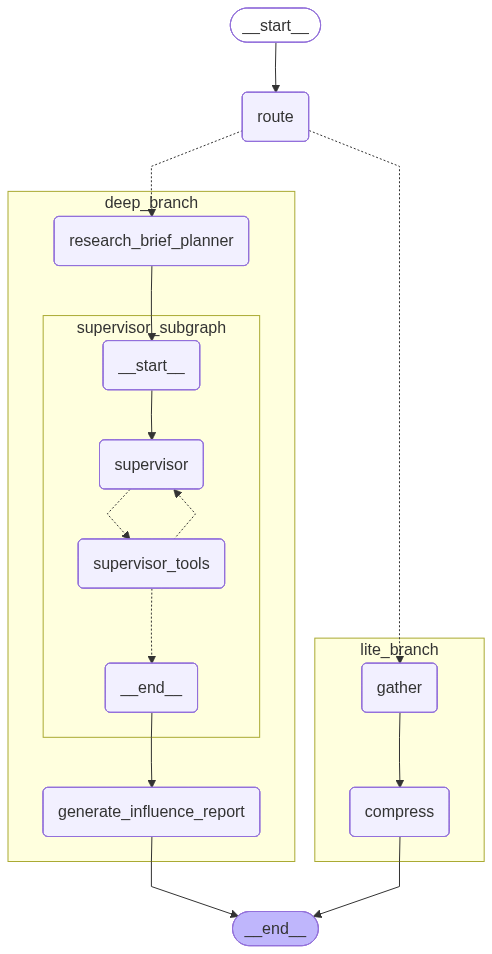

In [4]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import InMemorySaver
from deep_research.router import router_builder

checkpointer = InMemorySaver()
full_agent = router_builder.compile(checkpointer=checkpointer)
display(Image(full_agent.get_graph(xray=-1).draw_mermaid_png()))

In [5]:


import os
import json
import asyncio
from pathlib import Path
from typing import Any, Dict, List
from uuid import uuid4

from dotenv import load_dotenv
from langchain_core.messages import HumanMessage

load_dotenv()
API_KEY = os.getenv("GOOGLE_API_KEY")


def extract_model_response(result: Dict[str, Any]) -> Dict[str, Any]:
    """
    Extract the structured final_report object from the agent result.
    """
    final_report = result.get("final_report")
    if isinstance(final_report, dict):
        return final_report
    # Fallback: just wrap as dict
    return {"final_report_raw": final_report}


async def generate_model_responses_for_influence(
    gold_jsonl_path: str = "../dev_test/influence_gold.jsonl",
    output_jsonl_path: str = "../dev_test/influence_model_responses_2.jsonl",
    base_thread_id: str = "influence",
) -> None:
    """
    For each line in influence_gold.jsonl:
      - read {"question": "...", "gold_report": {...}}
      - call full_agent with that question
      - extract final_report
      - write {"query": question, "gold_report": ..., "model_response": ...} to output JSONL.

    If output_jsonl already has some entries, skip those queries and only run for the remaining ones.
    """
    gold_path = Path(gold_jsonl_path)
    out_path = Path(output_jsonl_path)

    if not gold_path.exists():
        raise FileNotFoundError(f"Gold file not found: {gold_path}")


    processed_queries: set[str] = set()
    if out_path.exists():
        with out_path.open("r", encoding="utf-8") as f_in:
            for line in f_in:
                line = line.strip()
                if not line:
                    continue
                try:
                    rec = json.loads(line)
                except json.JSONDecodeError:
                    continue
                q = rec.get("query")
                if isinstance(q, str):
                    processed_queries.add(q)

    print(f"[INFO] Already processed {len(processed_queries)} queries")

    with gold_path.open("r", encoding="utf-8") as fin, \
         out_path.open("a", encoding="utf-8") as fout:

        for idx, line in enumerate(fin):
            line = line.strip()
            if not line:
                continue

            record = json.loads(line)
            question = record.get("question")
            if not question:
                continue

            # 이미 처리된 query면 스킵
            if question in processed_queries:
                print(f"[SKIP] already processed query: {question}")
                continue

            thread_config = {
                "configurable": {
                    "thread_id": f"{base_thread_id}-{idx}-{uuid4()}",
                    "recursion_limit": 50,
                }
            }

            print(f"[RUN] query={question} (idx={idx})")

            result = await full_agent.ainvoke(
                {"messages": [HumanMessage(content=question)]},
                config=thread_config,
            )

            model_report = extract_model_response(result)

            out_obj = {
                "query": question,
                "gold_report": record.get("gold_report"),
                "model_response": model_report,
            }

            fout.write(json.dumps(out_obj, ensure_ascii=False) + "\n")
            fout.flush()


await generate_model_responses_for_influence()


[INFO] Already processed 19 queries
[SKIP] already processed query: 윤석열
[SKIP] already processed query: 이재명
[SKIP] already processed query: 문재인
[SKIP] already processed query: 박근혜
[SKIP] already processed query: 이명박
[SKIP] already processed query: 홍준표
[SKIP] already processed query: 안철수
[SKIP] already processed query: 이준석
[SKIP] already processed query: 심상정
[SKIP] already processed query: Joe Biden
[SKIP] already processed query: Donald Trump
[SKIP] already processed query: Xi Jinping
[SKIP] already processed query: Vladimir Putin
[SKIP] already processed query: Narendra Modi
[SKIP] already processed query: Rishi Sunak
[SKIP] already processed query: Emmanuel Macron
[SKIP] already processed query: Volodymyr Zelensky
[SKIP] already processed query: Fumio Kishida
[SKIP] already processed query: Mohammed bin Salman


In [6]:
import json
import asyncio
from pathlib import Path
from typing import Set

async def evaluate_influence_reports(
    input_jsonl_path: str = "../dev_test/influence_model_responses_2.jsonl",
    output_jsonl_path: str = "../dev_test/influence_model_responses_eval_3.jsonl",
) -> None:
    """
    input_jsonl_path:
      각 줄이
      {
        "query": "...",
        "gold_report": {...},
        "model_response": {...}
      }
      형태인 JSONL 파일.

    output_jsonl_path:
      각 줄이
      {
        "query": "...",
        "evaluation": {...}
      }
      형태인 JSONL 파일.
      이미 존재하면, 기존에 평가된 query는 스킵하고
      새 query만 append 한다.
    """

    in_path = Path(input_jsonl_path)
    out_path = Path(output_jsonl_path)

    if not in_path.exists():
        raise FileNotFoundError(f"Input file not found: {in_path}")

    # 1) 이미 평가된 query 읽어서 set에 저장
    processed_queries: Set[str] = set()
    if out_path.exists():
        with out_path.open("r", encoding="utf-8") as f_out_read:
            for line in f_out_read:
                line = line.strip()
                if not line:
                    continue
                try:
                    rec = json.loads(line)
                except json.JSONDecodeError:
                    continue
                q = rec.get("query")
                if isinstance(q, str):
                    processed_queries.add(q)

    print(f"[INFO] already processed {len(processed_queries)} queries")

    # 2) output은 append 모드로 열기 (이어쓰기)
    with in_path.open("r", encoding="utf-8") as fin, \
         out_path.open("a", encoding="utf-8") as fout:

        for idx, line in enumerate(fin):
            line = line.strip()
            if not line:
                continue

            record = json.loads(line)

            query = record.get("query")
            gold_report = record.get("gold_report")
            model_report = record.get("model_response")

            print(f"[DEBUG] Processing line {idx}, query={query}")
            print(f"[DEBUG] Gold report keys: {gold_report}")
            print(f"[DEBUG] Model report keys: {model_report}")
            

            if not query or not gold_report or not model_report:
                print(f"[WARN] line {idx}: missing fields, skipping")
                continue

            # 🔥 이미 평가한 query면 스킵
            if query in processed_queries:
                print(f"[SKIP] already evaluated query: {query}")
                continue

            # -----------------------------
            # 핵심: 평가 함수 호출
            # -----------------------------
            result = await evaluate_report_evidence(
                model_report=model_report,
                gold_report=gold_report,
                question=query,
            )

            out_record = {
                "query": query,
                "evaluation": result,
            }

            fout.write(json.dumps(out_record, ensure_ascii=False) + "\n")
            fout.flush()

            if (idx + 1) % 10 == 0:
                print(f"[INFO] processed {idx + 1} lines")

    print(f"[DONE] saved eval JSONL to {out_path}")


In [7]:
await evaluate_influence_reports()

[INFO] already processed 1 queries
[DEBUG] Processing line 0, query=윤석열
[DEBUG] Gold report keys: {'report_title': '윤석열 전 대통령의 정치·경제 영향력 네트워크 분석', 'time_range': '2025년 11월 24일 기준', 'question_answer': '윤석열 전 대통령은 원전 확대 정책으로 두산에너빌리티와 한국전력 등 원전 관련 기업에 수혜를 주었으며, 동시에 원전 중심 기조는 한화솔루션의 태양광 사업에 부정적 영향을 미쳤습니다. 또한 국방비 증액과 기술 육성 정책으로 방산 및 첨단산업 기업의 성장에 기여했으며, 미국·일본과의 동맹 강화 및 중동 경제협력 확대를 통해 국제적 영향력을 도모했습니다.', 'influence_chains': [{'politician': '윤석열', 'policy': '원전 확대 정책', 'industry_or_sector': '에너지/원전', 'companies': ['두산에너빌리티'], 'impact_description': '윤석열 정부가 신한울 3·4호기 건설 등 원전 사업을 재개하면서 두산에너빌리티가 원전 주기기 제작 수주와 SMR 기술 개발 지원을 받는 등 직접적 수혜를 입었습니다:contentReference[oaicite:0]{index=0}. 글로벌 에너지 위기 속 원전 수요 증가로 해당 기업의 재무 실적도 개선되었습니다.', 'evidence': [{'source_title': '윤석열 정책 수혜주 2편] 전 두산중공업(현 두산에너빌리티), 친원전 ...', 'url': 'https://contents.premium.naver.com/richplatform/therichplatform/contents/220416185027884GB'}]}, {'politician': '윤석열', 'policy': '원전 중심 에너지정책', 'industry_or_sector': '신재생에너지/태양광', 'companies': 

I0000 00:00:1764836510.637948 2051115 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764836510.649439 2051115 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764836510.654129 2051115 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers


['[DEBUG] evaluate_gold_node: question=이재명']
['[DEBUG] evaluate_gold_node: gold_report keys={\'report_title\': \'이재명 대통령의 정치·경제 영향력 네트워크 분석\', \'time_range\': \'2025년 11월 24일 기준\', \'question_answer\': \'이재명 대통령은 AI와 신재생에너지 육성 정책을 통해 삼성전자, 한화솔루션 등 미래 산업 기업들의 성장동력을 마련했으며, 남북 관계 개선 구상을 바탕으로 개성공단 입주 기업과 대북 사업 분야에도 긍정적 기대를 불러일으켰습니다. 동시에 지역화폐 지원 등 중소상공인 활성화 정책으로 핀테크 기업들의 수혜를 도모하고 있습니다.\', \'influence_chains\': [{\'politician\': \'이재명\', \'policy\': \'AI 산업 육성 정책\', \'industry_or_sector\': \'ICT/인공지능\', \'companies\': [\'네이버\', \'SK텔레콤\'], \'impact_description\': "이재명 정부는 \'AI 3대 강국 도약\'을 기치로 AI 연구개발을 적극 지원하고 있습니다. 그 결과 네이버, SK텔레콤 등 국내 AI 선도 기업들이 정부 주도 ‘국가대표 AI 기업’으로 선정되어 AI 모델 개발 프로젝트에 참여하며 주가와 투자심리가 개선되었습니다:contentReference[oaicite:5]{index=5}:contentReference[oaicite:6]{index=6}. 정부의 지속적인 지원으로 해당 기업들은 AI 인프라 확대와 글로벌 경쟁력 강화의 혜택을 보고 있습니다.", \'evidence\': [{\'source_title\': \'이재명정부 5년 청사진 곧 등장…장밋빛전망 가득한 ‘3대 정책 수혜주’\', \'url\': \'https://www.ledesk.co.kr/view.php?uid=13714\'}]}, {\'politicia

I0000 00:00:1764836547.022862 2051115 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764836547.036053 2051115 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers


['[DEBUG] evaluate_gold_node: question=이재명']
['[DEBUG] evaluate_gold_node: gold_report keys={\'report_title\': \'이재명 대통령의 정치·경제 영향력 네트워크 분석\', \'time_range\': \'2025년 11월 24일 기준\', \'question_answer\': \'이재명 대통령은 AI와 신재생에너지 육성 정책을 통해 삼성전자, 한화솔루션 등 미래 산업 기업들의 성장동력을 마련했으며, 남북 관계 개선 구상을 바탕으로 개성공단 입주 기업과 대북 사업 분야에도 긍정적 기대를 불러일으켰습니다. 동시에 지역화폐 지원 등 중소상공인 활성화 정책으로 핀테크 기업들의 수혜를 도모하고 있습니다.\', \'influence_chains\': [{\'politician\': \'이재명\', \'policy\': \'AI 산업 육성 정책\', \'industry_or_sector\': \'ICT/인공지능\', \'companies\': [\'네이버\', \'SK텔레콤\'], \'impact_description\': "이재명 정부는 \'AI 3대 강국 도약\'을 기치로 AI 연구개발을 적극 지원하고 있습니다. 그 결과 네이버, SK텔레콤 등 국내 AI 선도 기업들이 정부 주도 ‘국가대표 AI 기업’으로 선정되어 AI 모델 개발 프로젝트에 참여하며 주가와 투자심리가 개선되었습니다:contentReference[oaicite:5]{index=5}:contentReference[oaicite:6]{index=6}. 정부의 지속적인 지원으로 해당 기업들은 AI 인프라 확대와 글로벌 경쟁력 강화의 혜택을 보고 있습니다.", \'evidence\': [{\'source_title\': \'이재명정부 5년 청사진 곧 등장…장밋빛전망 가득한 ‘3대 정책 수혜주’\', \'url\': \'https://www.ledesk.co.kr/view.php?uid=13714\'}]}, {\'politicia

I0000 00:00:1764836570.189394 2051115 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers


['[DEBUG] evaluate_gold_node: question=이재명']
['[DEBUG] evaluate_gold_node: gold_report keys={\'report_title\': \'이재명 대통령의 정치·경제 영향력 네트워크 분석\', \'time_range\': \'2025년 11월 24일 기준\', \'question_answer\': \'이재명 대통령은 AI와 신재생에너지 육성 정책을 통해 삼성전자, 한화솔루션 등 미래 산업 기업들의 성장동력을 마련했으며, 남북 관계 개선 구상을 바탕으로 개성공단 입주 기업과 대북 사업 분야에도 긍정적 기대를 불러일으켰습니다. 동시에 지역화폐 지원 등 중소상공인 활성화 정책으로 핀테크 기업들의 수혜를 도모하고 있습니다.\', \'influence_chains\': [{\'politician\': \'이재명\', \'policy\': \'AI 산업 육성 정책\', \'industry_or_sector\': \'ICT/인공지능\', \'companies\': [\'네이버\', \'SK텔레콤\'], \'impact_description\': "이재명 정부는 \'AI 3대 강국 도약\'을 기치로 AI 연구개발을 적극 지원하고 있습니다. 그 결과 네이버, SK텔레콤 등 국내 AI 선도 기업들이 정부 주도 ‘국가대표 AI 기업’으로 선정되어 AI 모델 개발 프로젝트에 참여하며 주가와 투자심리가 개선되었습니다:contentReference[oaicite:5]{index=5}:contentReference[oaicite:6]{index=6}. 정부의 지속적인 지원으로 해당 기업들은 AI 인프라 확대와 글로벌 경쟁력 강화의 혜택을 보고 있습니다.", \'evidence\': [{\'source_title\': \'이재명정부 5년 청사진 곧 등장…장밋빛전망 가득한 ‘3대 정책 수혜주’\', \'url\': \'https://www.ledesk.co.kr/view.php?uid=13714\'}]}, {\'politicia

I0000 00:00:1764836587.544132 2051115 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers


['[DEBUG] evaluate_gold_node: question=이재명']
['[DEBUG] evaluate_gold_node: gold_report keys={\'report_title\': \'이재명 대통령의 정치·경제 영향력 네트워크 분석\', \'time_range\': \'2025년 11월 24일 기준\', \'question_answer\': \'이재명 대통령은 AI와 신재생에너지 육성 정책을 통해 삼성전자, 한화솔루션 등 미래 산업 기업들의 성장동력을 마련했으며, 남북 관계 개선 구상을 바탕으로 개성공단 입주 기업과 대북 사업 분야에도 긍정적 기대를 불러일으켰습니다. 동시에 지역화폐 지원 등 중소상공인 활성화 정책으로 핀테크 기업들의 수혜를 도모하고 있습니다.\', \'influence_chains\': [{\'politician\': \'이재명\', \'policy\': \'AI 산업 육성 정책\', \'industry_or_sector\': \'ICT/인공지능\', \'companies\': [\'네이버\', \'SK텔레콤\'], \'impact_description\': "이재명 정부는 \'AI 3대 강국 도약\'을 기치로 AI 연구개발을 적극 지원하고 있습니다. 그 결과 네이버, SK텔레콤 등 국내 AI 선도 기업들이 정부 주도 ‘국가대표 AI 기업’으로 선정되어 AI 모델 개발 프로젝트에 참여하며 주가와 투자심리가 개선되었습니다:contentReference[oaicite:5]{index=5}:contentReference[oaicite:6]{index=6}. 정부의 지속적인 지원으로 해당 기업들은 AI 인프라 확대와 글로벌 경쟁력 강화의 혜택을 보고 있습니다.", \'evidence\': [{\'source_title\': \'이재명정부 5년 청사진 곧 등장…장밋빛전망 가득한 ‘3대 정책 수혜주’\', \'url\': \'https://www.ledesk.co.kr/view.php?uid=13714\'}]}, {\'politicia

I0000 00:00:1764836618.782980 2051115 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764836618.789696 2051115 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers


['[DEBUG] evaluate_gold_node: question=문재인']
["[DEBUG] evaluate_gold_node: gold_report keys={'report_title': '문재인 전 대통령의 정치·경제 영향력 네트워크 분석', 'time_range': '2017–2022', 'question_answer': '문재인 전 대통령은 탈원전과 그린뉴딜 정책을 추진하여 태양광·풍력 등 신재생에너지 산업을 육성했고, 4대강 보 철거와 생태 복원 정책으로 환경 관련 기업에 새로운 기회를 제공했습니다. 또한 남북 화해 기조를 바탕으로 개성공단 재가동을 모색하며 남북경협 관련 기업들의 주가에 영향을 미쳤으며, 수소경제 등 미래 산업 투자로 현대모비스 등 친환경차 부품 기업이 성장하는 계기를 마련했습니다.', 'influence_chains': [{'politician': '문재인', 'policy': '탈원전 및 재생에너지 정책', 'industry_or_sector': '에너지/태양광', 'companies': ['한화솔루션', 'OCI'], 'impact_description': '문재인 정부는 신규 원전 건설 백지화와 신재생에너지 비중 확대를 추진하여 태양광 등 친환경 에너지 업계를 부양했습니다. 이로 인해 국내 태양광 대표 기업 한화솔루션과 폴리실리콘 생산업체 OCI 등이 정부 보조금과 시장 확대의 혜택을 입어 실적이 개선되고 주가가 상승했습니다:contentReference[oaicite:11]{index=11}:contentReference[oaicite:12]{index=12}. 반면 원전 관련 산업은 위축되었으나 재생에너지 분야는 정책 지원에 힘입어 성장 기반을 마련했습니다.', 'evidence': [{'source_title': '문재인 정책株, 4대강 복원·개성공단 관련주 급등...테마주는 약세', 'url': 'https://www.thevaluenews.co.kr/news/6918'}]}, {'politician': '문재인'

I0000 00:00:1764836673.187653 2051115 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers


['[DEBUG] evaluate_gold_node: question=문재인']
["[DEBUG] evaluate_gold_node: gold_report keys={'report_title': '문재인 전 대통령의 정치·경제 영향력 네트워크 분석', 'time_range': '2017–2022', 'question_answer': '문재인 전 대통령은 탈원전과 그린뉴딜 정책을 추진하여 태양광·풍력 등 신재생에너지 산업을 육성했고, 4대강 보 철거와 생태 복원 정책으로 환경 관련 기업에 새로운 기회를 제공했습니다. 또한 남북 화해 기조를 바탕으로 개성공단 재가동을 모색하며 남북경협 관련 기업들의 주가에 영향을 미쳤으며, 수소경제 등 미래 산업 투자로 현대모비스 등 친환경차 부품 기업이 성장하는 계기를 마련했습니다.', 'influence_chains': [{'politician': '문재인', 'policy': '탈원전 및 재생에너지 정책', 'industry_or_sector': '에너지/태양광', 'companies': ['한화솔루션', 'OCI'], 'impact_description': '문재인 정부는 신규 원전 건설 백지화와 신재생에너지 비중 확대를 추진하여 태양광 등 친환경 에너지 업계를 부양했습니다. 이로 인해 국내 태양광 대표 기업 한화솔루션과 폴리실리콘 생산업체 OCI 등이 정부 보조금과 시장 확대의 혜택을 입어 실적이 개선되고 주가가 상승했습니다:contentReference[oaicite:11]{index=11}:contentReference[oaicite:12]{index=12}. 반면 원전 관련 산업은 위축되었으나 재생에너지 분야는 정책 지원에 힘입어 성장 기반을 마련했습니다.', 'evidence': [{'source_title': '문재인 정책株, 4대강 복원·개성공단 관련주 급등...테마주는 약세', 'url': 'https://www.thevaluenews.co.kr/news/6918'}]}, {'politician': '문재인'

I0000 00:00:1764836709.729750 2051115 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers


['[DEBUG] evaluate_gold_node: question=문재인']
["[DEBUG] evaluate_gold_node: gold_report keys={'report_title': '문재인 전 대통령의 정치·경제 영향력 네트워크 분석', 'time_range': '2017–2022', 'question_answer': '문재인 전 대통령은 탈원전과 그린뉴딜 정책을 추진하여 태양광·풍력 등 신재생에너지 산업을 육성했고, 4대강 보 철거와 생태 복원 정책으로 환경 관련 기업에 새로운 기회를 제공했습니다. 또한 남북 화해 기조를 바탕으로 개성공단 재가동을 모색하며 남북경협 관련 기업들의 주가에 영향을 미쳤으며, 수소경제 등 미래 산업 투자로 현대모비스 등 친환경차 부품 기업이 성장하는 계기를 마련했습니다.', 'influence_chains': [{'politician': '문재인', 'policy': '탈원전 및 재생에너지 정책', 'industry_or_sector': '에너지/태양광', 'companies': ['한화솔루션', 'OCI'], 'impact_description': '문재인 정부는 신규 원전 건설 백지화와 신재생에너지 비중 확대를 추진하여 태양광 등 친환경 에너지 업계를 부양했습니다. 이로 인해 국내 태양광 대표 기업 한화솔루션과 폴리실리콘 생산업체 OCI 등이 정부 보조금과 시장 확대의 혜택을 입어 실적이 개선되고 주가가 상승했습니다:contentReference[oaicite:11]{index=11}:contentReference[oaicite:12]{index=12}. 반면 원전 관련 산업은 위축되었으나 재생에너지 분야는 정책 지원에 힘입어 성장 기반을 마련했습니다.', 'evidence': [{'source_title': '문재인 정책株, 4대강 복원·개성공단 관련주 급등...테마주는 약세', 'url': 'https://www.thevaluenews.co.kr/news/6918'}]}, {'politician': '문재인'

I0000 00:00:1764836728.666458 2051115 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers


['[DEBUG] evaluate_gold_node: question=박근혜']
['[DEBUG] evaluate_gold_node: gold_report keys={\'report_title\': \'박근혜 전 대통령의 정치·경제 영향력 네트워크 분석\', \'time_range\': \'2013–2017\', \'question_answer\': \'박근혜 전 대통령은 창조경제와 문화융성 정책을 통해 사물인터넷·3D프린팅 등 신산업 분야 스타트업과 한류 콘텐츠 기업들의 성장을 도모했습니다. 또한 중동 순방 경제외교를 통해 대형 건설사의 해외수주를 지원했고, 부동산 활성화를 위한 규제 완화로 건설경기에 긍정적인 영향을 미쳤습니다. 그러나 최순실 사태로 일부 기업과의 부정적 연결 고리가 드러나며 정책 추진에 대한 신뢰성이 타격을 입었습니다.\', \'influence_chains\': [{\'politician\': \'박근혜\', \'policy\': \'창조경제 산업육성\', \'industry_or_sector\': \'ICT/신산업\', \'companies\': [\'TPC(티피씨)\', \'효성ITX\'], \'impact_description\': \'박근혜 정부는 ICT 기반 창조경제를 내세워 사물인터넷, 3D프린팅 등 4차산업혁명 관련 기업을 지원했습니다. 그 영향으로 3D 프린터 제조사 TPC 등 관련주들이 정책 발표 직후 급등하는 등 수혜를 입었고:contentReference[oaicite:19]{index=19}:contentReference[oaicite:20]{index=20}, 효성ITX 등 일부 IT기업 주가는 창조경제 언급 때마다 상승세를 보였습니다. 이는 정부의 규제 완화와 R&D 지원에 대한 기대감이 해당 기업들의 성장 모멘텀으로 작용한 사례입니다.\', \'evidence\': [{\'source_title\': "[상반기 달군 테마주] 朴대통령 “창조경제” 발언에 사물인터넷株 \'고공행진\'", \'url\': \'htt

I0000 00:00:1764836768.473638 2051115 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers


['[DEBUG] evaluate_gold_node: question=박근혜']
['[DEBUG] evaluate_gold_node: gold_report keys={\'report_title\': \'박근혜 전 대통령의 정치·경제 영향력 네트워크 분석\', \'time_range\': \'2013–2017\', \'question_answer\': \'박근혜 전 대통령은 창조경제와 문화융성 정책을 통해 사물인터넷·3D프린팅 등 신산업 분야 스타트업과 한류 콘텐츠 기업들의 성장을 도모했습니다. 또한 중동 순방 경제외교를 통해 대형 건설사의 해외수주를 지원했고, 부동산 활성화를 위한 규제 완화로 건설경기에 긍정적인 영향을 미쳤습니다. 그러나 최순실 사태로 일부 기업과의 부정적 연결 고리가 드러나며 정책 추진에 대한 신뢰성이 타격을 입었습니다.\', \'influence_chains\': [{\'politician\': \'박근혜\', \'policy\': \'창조경제 산업육성\', \'industry_or_sector\': \'ICT/신산업\', \'companies\': [\'TPC(티피씨)\', \'효성ITX\'], \'impact_description\': \'박근혜 정부는 ICT 기반 창조경제를 내세워 사물인터넷, 3D프린팅 등 4차산업혁명 관련 기업을 지원했습니다. 그 영향으로 3D 프린터 제조사 TPC 등 관련주들이 정책 발표 직후 급등하는 등 수혜를 입었고:contentReference[oaicite:19]{index=19}:contentReference[oaicite:20]{index=20}, 효성ITX 등 일부 IT기업 주가는 창조경제 언급 때마다 상승세를 보였습니다. 이는 정부의 규제 완화와 R&D 지원에 대한 기대감이 해당 기업들의 성장 모멘텀으로 작용한 사례입니다.\', \'evidence\': [{\'source_title\': "[상반기 달군 테마주] 朴대통령 “창조경제” 발언에 사물인터넷株 \'고공행진\'", \'url\': \'htt

I0000 00:00:1764836792.485836 2051115 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers


['[DEBUG] evaluate_gold_node: question=박근혜']
['[DEBUG] evaluate_gold_node: gold_report keys={\'report_title\': \'박근혜 전 대통령의 정치·경제 영향력 네트워크 분석\', \'time_range\': \'2013–2017\', \'question_answer\': \'박근혜 전 대통령은 창조경제와 문화융성 정책을 통해 사물인터넷·3D프린팅 등 신산업 분야 스타트업과 한류 콘텐츠 기업들의 성장을 도모했습니다. 또한 중동 순방 경제외교를 통해 대형 건설사의 해외수주를 지원했고, 부동산 활성화를 위한 규제 완화로 건설경기에 긍정적인 영향을 미쳤습니다. 그러나 최순실 사태로 일부 기업과의 부정적 연결 고리가 드러나며 정책 추진에 대한 신뢰성이 타격을 입었습니다.\', \'influence_chains\': [{\'politician\': \'박근혜\', \'policy\': \'창조경제 산업육성\', \'industry_or_sector\': \'ICT/신산업\', \'companies\': [\'TPC(티피씨)\', \'효성ITX\'], \'impact_description\': \'박근혜 정부는 ICT 기반 창조경제를 내세워 사물인터넷, 3D프린팅 등 4차산업혁명 관련 기업을 지원했습니다. 그 영향으로 3D 프린터 제조사 TPC 등 관련주들이 정책 발표 직후 급등하는 등 수혜를 입었고:contentReference[oaicite:19]{index=19}:contentReference[oaicite:20]{index=20}, 효성ITX 등 일부 IT기업 주가는 창조경제 언급 때마다 상승세를 보였습니다. 이는 정부의 규제 완화와 R&D 지원에 대한 기대감이 해당 기업들의 성장 모멘텀으로 작용한 사례입니다.\', \'evidence\': [{\'source_title\': "[상반기 달군 테마주] 朴대통령 “창조경제” 발언에 사물인터넷株 \'고공행진\'", \'url\': \'htt

I0000 00:00:1764836829.753017 2051115 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764836829.765948 2051115 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764836829.770555 2051115 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers


['[DEBUG] evaluate_gold_node: question=박근혜']
['[DEBUG] evaluate_gold_node: gold_report keys={\'report_title\': \'박근혜 전 대통령의 정치·경제 영향력 네트워크 분석\', \'time_range\': \'2013–2017\', \'question_answer\': \'박근혜 전 대통령은 창조경제와 문화융성 정책을 통해 사물인터넷·3D프린팅 등 신산업 분야 스타트업과 한류 콘텐츠 기업들의 성장을 도모했습니다. 또한 중동 순방 경제외교를 통해 대형 건설사의 해외수주를 지원했고, 부동산 활성화를 위한 규제 완화로 건설경기에 긍정적인 영향을 미쳤습니다. 그러나 최순실 사태로 일부 기업과의 부정적 연결 고리가 드러나며 정책 추진에 대한 신뢰성이 타격을 입었습니다.\', \'influence_chains\': [{\'politician\': \'박근혜\', \'policy\': \'창조경제 산업육성\', \'industry_or_sector\': \'ICT/신산업\', \'companies\': [\'TPC(티피씨)\', \'효성ITX\'], \'impact_description\': \'박근혜 정부는 ICT 기반 창조경제를 내세워 사물인터넷, 3D프린팅 등 4차산업혁명 관련 기업을 지원했습니다. 그 영향으로 3D 프린터 제조사 TPC 등 관련주들이 정책 발표 직후 급등하는 등 수혜를 입었고:contentReference[oaicite:19]{index=19}:contentReference[oaicite:20]{index=20}, 효성ITX 등 일부 IT기업 주가는 창조경제 언급 때마다 상승세를 보였습니다. 이는 정부의 규제 완화와 R&D 지원에 대한 기대감이 해당 기업들의 성장 모멘텀으로 작용한 사례입니다.\', \'evidence\': [{\'source_title\': "[상반기 달군 테마주] 朴대통령 “창조경제” 발언에 사물인터넷株 \'고공행진\'", \'url\': \'htt

I0000 00:00:1764836869.152127 2051115 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764836869.164510 2051115 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers


['[DEBUG] evaluate_gold_node: question=박근혜']
['[DEBUG] evaluate_gold_node: gold_report keys={\'report_title\': \'박근혜 전 대통령의 정치·경제 영향력 네트워크 분석\', \'time_range\': \'2013–2017\', \'question_answer\': \'박근혜 전 대통령은 창조경제와 문화융성 정책을 통해 사물인터넷·3D프린팅 등 신산업 분야 스타트업과 한류 콘텐츠 기업들의 성장을 도모했습니다. 또한 중동 순방 경제외교를 통해 대형 건설사의 해외수주를 지원했고, 부동산 활성화를 위한 규제 완화로 건설경기에 긍정적인 영향을 미쳤습니다. 그러나 최순실 사태로 일부 기업과의 부정적 연결 고리가 드러나며 정책 추진에 대한 신뢰성이 타격을 입었습니다.\', \'influence_chains\': [{\'politician\': \'박근혜\', \'policy\': \'창조경제 산업육성\', \'industry_or_sector\': \'ICT/신산업\', \'companies\': [\'TPC(티피씨)\', \'효성ITX\'], \'impact_description\': \'박근혜 정부는 ICT 기반 창조경제를 내세워 사물인터넷, 3D프린팅 등 4차산업혁명 관련 기업을 지원했습니다. 그 영향으로 3D 프린터 제조사 TPC 등 관련주들이 정책 발표 직후 급등하는 등 수혜를 입었고:contentReference[oaicite:19]{index=19}:contentReference[oaicite:20]{index=20}, 효성ITX 등 일부 IT기업 주가는 창조경제 언급 때마다 상승세를 보였습니다. 이는 정부의 규제 완화와 R&D 지원에 대한 기대감이 해당 기업들의 성장 모멘텀으로 작용한 사례입니다.\', \'evidence\': [{\'source_title\': "[상반기 달군 테마주] 朴대통령 “창조경제” 발언에 사물인터넷株 \'고공행진\'", \'url\': \'htt

I0000 00:00:1764836907.299651 2051115 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764836907.312231 2051115 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers


CancelledError: 

In [7]:
from typing import Dict, Any, List, Optional

VERTEX_PREFIX = "vertexaisearch.cloud.google.com/grounding-api-redirect"


def _is_valid_evidence_item(item: Dict[str, Any]) -> bool:
    """
    Return True if this evidence item should be used for scoring.
    Filters out:
      - vertex grounding redirect URLs
      - NOT_ENOUGH_INFO labels
    """
    url = (item.get("url") or "").lower()
    if VERTEX_PREFIX in url:
        return False

    label = item.get("label")
    if label == "NOT_ENOUGH_INFO":
        return False

    return True


def extract_scores_from_record(record: Dict[str, Any]) -> Dict[str, Any]:
    """
    Given a single JSON record like:
      { "query": "...", "evaluation": { ... } }

    Return:
      {
        "impact_scores": [...],
        "attribution_scores": [...],
        "gold_score": float | None
      }

    Filtering:
      - Exclude evidence items whose URL is a vertex grounding redirect
      - Exclude items with label == "NOT_ENOUGH_INFO"
    """
    evaluation = record.get("evaluation", {}) or {}
    chain_results: List[Dict[str, Any]] = evaluation.get("chain_results", []) or []

    impact_scores: List[float] = []
    attribution_scores: List[float] = []

    for chain in chain_results:
        # Impact Evidence scores
        for item in chain.get("impact_results", []) or []:
            if not _is_valid_evidence_item(item):
                continue
            score = item.get("score")
            if isinstance(score, (int, float)):
                impact_scores.append(float(score))

        # Policy Attribution scores
        for item in chain.get("attribution_results", []) or []:
            if not _is_valid_evidence_item(item):
                continue
            score = item.get("score")
            if isinstance(score, (int, float)):
                attribution_scores.append(float(score))

    gold_eval = evaluation.get("gold_eval", {}) or {}
    gold_score = gold_eval.get("similarity_score")
    if not isinstance(gold_score, (int, float)):
        gold_score = None

    return {
        "impact_scores": impact_scores,
        "attribution_scores": attribution_scores,
        "gold_score": gold_score,
    }


def _mean(xs: List[float]) -> Optional[float]:
    return sum(xs) / len(xs) if xs else None


def compute_averages_for_record(record: Dict[str, Any]) -> Dict[str, Optional[float]]:
    """
    For a single record, return average scores for:
      - impact
      - attribution
      - gold similarity

    Example output:
      {
        "impact_avg": 0.35,
        "attribution_avg": 0.62,
        "gold_avg": 0.7
      }
    """
    scores = extract_scores_from_record(record)

    impact_avg = _mean(scores["impact_scores"])
    attribution_avg = _mean(scores["attribution_scores"])
    gold_avg = scores["gold_score"]  # gold은 이미 하나의 값

    return {
        "impact_avg": impact_avg,
        "attribution_avg": attribution_avg,
        "gold_avg": gold_avg,
    }



def compute_averages_from_jsonl(path: str) -> Dict[str, Optional[float]]:
    """
    Read a JSONL file where each line is:
      { "query": "...", "evaluation": {...} }

    Aggregate all valid scores across records and compute global averages.
    """
    p = Path(path)
    if not p.exists():
        raise FileNotFoundError(p)

    all_impact: List[float] = []
    all_attr: List[float] = []
    all_gold: List[float] = []

    with p.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            record: Dict[str, Any] = json.loads(line)

            per = extract_scores_from_record(record)
            all_impact.extend(per["impact_scores"])
            all_attr.extend(per["attribution_scores"])
            if per["gold_score"] is not None:
                all_gold.append(per["gold_score"])

    return {
        "impact_avg": _mean(all_impact),
        "attribution_avg": _mean(all_attr),
        "gold_avg": _mean(all_gold),
    }



In [14]:
import json

print(json.dumps(chain_results[0], indent=2, ensure_ascii=False))

NameError: name 'chain_results' is not defined

In [13]:
compute_averages_from_jsonl("../dev_test/influence_model_responses_eval_2.jsonl")

{'impact_avg': None, 'attribution_avg': None, 'gold_avg': 0.725}